In [ ]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

# VEST ME 2018

## VEST's Documentation File

Election results by township from Maine Bureau of Corporations, Elections & Commissions (https://www.maine.gov/sos/cec/elec/results/index.html)
Election results by ward from municipal reports for Auburn, Augusta, Belfast, Biddeford, Ellsworth, Gorham, Harpswell, Lewiston, Portland, Saco, Sanford, South Portland, Westbrook.

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. Voting District shapefiles were available for Androscoggin, Cumberland, Kennebec, Sagadahoc, Waldo, York. County Subdivision shapefiles were used instead for Aroostook, Franklin, Hancock, Knox, Lincoln, Oxford, Penobscot, Piscataquis, Somerset, Washington.

VTDs were merged for Bath, Brunswick, Waterville as statewide votes are not reported by ward. VTDs for Biddeford, Ellsworth, Gorham, Harpswell were sourced from township ward maps.

Absentee votes were reported at the township level for Auburn, Lewiston, Gorham, Harpswell, Portland, Westbrook, Augusta, Belfast, Sanford, South Portland. These were distributed to precincts based on the precinct's share of the township vote for each candidate. Military and overseas ballots (UOCAVA) were reported at the state level. These were distributed to precincts based on the precinct's share of the statewide vote for each candidate.

For Auburn, Biddeford, Lewiston write-in votes reported at the township level were apportioned to precincts in the same shares that the total vote was split among precincts within the township.

The state reported 4930 votes from Gorham for Angus King (I). The precinct-level votes in the Gorham city report add up to 4530 total votes for King. The state reported 4201 votes from Portland for Eric Brakey (R). The precinct-level votes in the Portland city report add up to 4200 total votes for Brakey.

Maine features more than 400 unorganized townships and islands that do not lie within municipal bounds. While some are designated separately, the U.S. Census Bureau combines most of these into larger unorganized territories within each county. Voters in unorganized townships are assigned to nearby incorporated townships. In some cases these votes are reported separately while in others they are combined into the total vote reported from the central voting location. The shapefile has been modified accordingly with boundaries from the Town Boundaries shapefile provided by the Maine Office of GIS. For unorganized territories that are unpopulated or otherwise do not appear to have any registered voters the Census boundaries have been retained unaltered.

G18GOVDMIL - Janet T. Mills (Democratic Party)  
G18GOVRMOO - Shawn Moody (Republican Party)  
G18GOVIHAY - Teresea Hayes (Independent)  
G18GOVOWRI - Write-in Votes  
  
G18USSDRIN - Zak Ringelstein (Democratic Party)  
G18USSRBRA - Eric Brakey (Republican Party)  
G18USSIKIN - Angus King (Independent)  
G18USSOWRI - Write-in Votes  

## Load VEST's Final File

In [ ]:
vest_me_18 = gp.read_file("./raw-from-source/VEST/me_2018/me_2018.shp")

In [ ]:
vest_me_18.shape

In [ ]:
vest_me_18.head(1)

In [ ]:
vest_me_18.boundary.plot()

# Election Results

## Load in Election Results

Downloaded SOS Election Results using the same file linked by VEST, and cleaned them in Excel. Results do not require pivoting. 

In [ ]:
gov_results = pd.read_csv('./raw-from-source/SOS/governor11-6-18_clean.csv')
sen_results = pd.read_csv('./raw-from-source/SOS/us-senate11-6-18_clean.csv')
gov_results["join_col"]=gov_results['County']+gov_results['Precinct']
sen_results["join_col"]=sen_results['County']+sen_results['Precinct']
gov_results['join_col']=gov_results['join_col'].str.strip()
sen_results['join_col']=sen_results['join_col'].str.strip()

In [ ]:
join_attempt_one = pd.merge(gov_results,sen_results,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

In [ ]:
pd.set_option('display.max_rows', 10)
join_attempt_one[join_attempt_one['_merge'] != 'both'][['County_x','Precinct_x','County_y','Precinct_y','join_col']]

In [ ]:
#Change names for the precincts that didn't join
election_names_dict = {
'AROT15 R6 Twp (Eagle Lake & Winterville Plt)':'AROT15 R6 Twp (Eagle Lake & Wintervlle Plt)',
'WASBerry/Cathance/Marion Twps (East Machias)':'WASBerry/Cathance/MarionTwps (East Machias)'    
}

In [ ]:
#Use the dictionary to change the names
sen_results["join_col"]=sen_results["join_col"].map(election_names_dict).fillna(sen_results["join_col"])

In [ ]:
#Attempt the join again
join_attempt_two = pd.merge(gov_results,sen_results,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

election_results = join_attempt_two.copy()

In [ ]:
#Take a look
election_results.head(1)

## Add in FIPS data

In [ ]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Maine"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Make FIPS County Name uppercase
fips_file['County Name']=fips_file['County Name'].str.upper()

#Create the dictionary
me_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))
#Create list of fips codes
fips_file["unique_ID"] =  "23" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()

In [ ]:
#Create another dictionary to go from abbreviations to full names
election_results["County_x"].unique()

County_dict = {
    'AND':'ANDROSCOGGIN', 
    'ARO':'AROOSTOOK', 
    'CUM':'CUMBERLAND', 
    'FRA':'FRANKLIN', 
    'HAN':'HANCOCK', 
    'KEN':'KENNEBEC', 
    'KNO':'KNOX', 
    'LIN':'LINCOLN', 
    'OXF':'OXFORD',
    'PEN':'PENOBSCOT', 
    'PIS':'PISCATAQUIS', 
    'SAG':'SAGADAHOC', 
    'SOM':'SOMERSET', 
    'WAL':'WALDO', 
    'WAS':'WASHINGTON', 
    'YOR':'YORK'
}

In [ ]:
#Use the dictionary to change the names
election_results["County_x"]=election_results["County_x"].map(County_dict).fillna(election_results["County_x"])

#Map to the correct FIP
election_results["County_FIPS"]=election_results["County_x"].map(me_fips_dict).fillna(election_results["County_x"])

#Print out the FIPS to make sure they all are in the correct format
election_results["County_x"].unique()

## Clean up Election Results and VEST file

In [ ]:
#Drop and filter down to relevant columns
election_results = election_results.drop(['join_col', 'County_y','Precinct_y','_merge'], axis=1)
election_results = election_results[["County_x","Precinct_x","County_FIPS","Mills, Janet T.","Moody, Shawn H.","Hayes, Teresea M.","Others_x","Ringelstein, Zak","Brakey, Eric L.","King, Angus S. Jr.","Others_y"]]

#Rename the columns
election_results.columns = ["County","Precinct","County_FIPS","G18GOVDMIL","G18GOVRMOO","G18GOVIHAY","G18GOVOWRI","G18USSDRIN","G18USSRBRA","G18USSIKIN","G18USSOWRI"]

#Take a look
election_results.head(1)

In [ ]:
#Modify the COUNTYFP column
vest_me_18['COUNTYFP']=vest_me_18['COUNTYFP'].str.upper()

#Add in the FIPS number
vest_me_18["County_FIPS"]=vest_me_18["COUNTYFP"].map(me_fips_dict).fillna(vest_me_18["COUNTYFP"])

#Take a look
vest_me_18

## Compare vote totals before allocation: not expecting to be equal

In [ ]:
races = [x for x in vest_me_18.columns if 'G18' in x]
races

Almost matches b/c SOS file contains it, just not broken up by precinct.
Election_results not including absentee

In [ ]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_me_18[i])
    sum_var_2 += np.sum(election_results[i])
print(sum_var_1)
print(sum_var_2)

## Function to assign absentee votes by town

In [ ]:
def assign_absentee(filtered_election):
    to_dole_out = filtered_election[filtered_election['Precinct']=='Absentee']
    to_dole_out_totals = to_dole_out
    filtered_election = filtered_election[filtered_election.Precinct != 'Absentee']
    #Create a df with the county-by-county sums of precinct-level votes, this will be used in the allocation, clean the index
    precinct_specific_totals = pd.DataFrame(filtered_election.groupby(["County"]).sum())
    precinct_specific_totals.reset_index(inplace=True,drop=False)
    filtered_election.reset_index(inplace=True,drop=True)
    
    for race in races:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        filtered_election.loc[:,add_var]=0.0
        filtered_election.loc[:,rem_var]=0.0
        filtered_election.loc[:,floor_var]=0.0
    
    for index, row in filtered_election.iterrows():
        #No countywide votes for 510
        if row["County"] in to_dole_out['County'].unique():
            for race in races:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the county
                county_id = row["County"]
                #Get the denominator for the allocation (the precinct vote totals)
                denom = precinct_specific_totals.loc[precinct_specific_totals["County"]==county_id][race]
                #Get one of the numerators, how many countywide votes to allocate
                numer = to_dole_out_totals.loc[to_dole_out_totals["County"]==county_id][race]

                #Get the vote totals for this race in this precinct
                val = filtered_election.loc[index,race]

                #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
                if float(denom) !=0:
                    vote_share = (float(val)/float(denom))*float(numer)
                else:
                    vote_share = 0


                filtered_election.loc[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                filtered_election.loc[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                filtered_election.loc[index,floor_var] = np.floor(vote_share)
                
    #After the first pass through, get the sums of the races by county            
    first_allocation = pd.DataFrame(filtered_election.groupby(["County"]).sum())

    #Now we want to iterate county by county to work on rounding
    county_list = list(to_dole_out_totals["County"].unique()) 

    #Iterate over the counties
    for county in county_list:
        for race in races:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals["County"]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in filtered_election.loc[filtered_election["County"]==county][rem_var].nlargest(to_go).index:
                filtered_election.loc[index,add_var] = np.ceil(filtered_election.loc[index,add_var])

    #Iterate over every race again
    for race in races:
        add_var = race+"_add"
        #Round every allocation down
        filtered_election.loc[:,add_var]=np.floor(filtered_election.loc[:,add_var])
        #Add every allocation to the total
        filtered_election.loc[:,race]+=filtered_election.loc[:,add_var]
        
    special_allocation = []
    for index, row in precinct_specific_totals.iterrows():
        for race in races:
            if (row[race]==0):
                race_district = row["County"]
                if race_district in to_dole_out_totals["County"].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals["County"]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    

    #Filter back down to the original columns
    filtered_election = filtered_election[list(election_results.columns)]
    return filtered_election

## Assign votes by ward for Auburn, Augusta, Belfast, Biddeford, Ellsworth, Gorham, Harpswell, Lewiston, Portland, Saco, Sanford, South Portland, Westbrook.

VEST:  
- Election results by ward from municipal reports for Auburn, Augusta, Belfast, Biddeford, Ellsworth, Gorham, Harpswell, Lewiston, Portland, Saco, Sanford, South Portland, Westbrook.  
- Absentee votes were reported at the township level for Auburn, Lewiston, Gorham, Harpswell, Portland, Westbrook, Augusta, Belfast, Sanford, South Portland. These were distributed to precincts based on the precinct's share of the township vote for each candidate.  
- For Auburn, Biddeford, Lewiston write-in votes reported at the township level were apportioned to precincts in the same shares that the total vote was split among precincts within the township.  


### Auburn
Source-https://www.auburnmaine.gov/CMSContent/City_Clerk/OFFICIAL%20RESULTS%20-%20BY%20WARD.pdf

In [ ]:
Auburn_dict = {'County':['ANDROSCOGGIN', 'ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN'],
        'Precinct':['Auburn Ward 1', 'Auburn Ward 2', 'Auburn Ward 3','Auburn Ward 4','Auburn Ward 5','Absentee'],
        'County_FIPS':['001', '001','001','001','001','001'],
        'G18GOVDMIL':[581,768,540,465,583,1641],
        'G18GOVRMOO':[608,596,699,549,672,1111],
        'G18GOVIHAY':[111,105,88,94,112,190],
        'G18GOVOWRI':[6,0,0,0,0,7],
        'G18USSDRIN':[147,157,100,95,129,234],
        'G18USSRBRA':[548,556,582,508,633,986],
        'G18USSIKIN':[629,769,651,515,625,1756],
        'G18USSOWRI':[0,0,0,0,0,0]
       }
Auburn_df = pd.DataFrame(Auburn_dict)
Auburn_df = assign_absentee(Auburn_df)
Auburn_df

### Augusta
source-Email from town. File available upon request

In [ ]:
Augusta_dict = {'County':['KENNEBEC', 'KENNEBEC','KENNEBEC','KENNEBEC','KENNEBEC'],
        'Precinct':['Augusta Ward 1', 'Augusta Ward 2', 'Augusta Ward 3','Augusta Ward 4','Absentee'],
        'County_FIPS':['011', '011','011','011','011'],
        'G18GOVDMIL':[648,676,556,691,1447],
        'G18GOVRMOO':[438,496,627,667,870],
        'G18GOVIHAY':[69,78,83,90,120],
        'G18GOVOWRI':[0,0,0,0,0],
        'G18USSDRIN':[149,124,97,161,180],
        'G18USSRBRA':[335,419,523,540,722],
        'G18USSIKIN':[669,728,637,742,1563],
        'G18USSOWRI':[0,0,0,0,0]
       }
Augusta_df = pd.DataFrame(Augusta_dict)
Augusta_df = assign_absentee(Augusta_df)
Augusta_df

### Belfast
source-https://www.cityofbelfast.org/DocumentCenter/View/3466/City-Clerks-Return-Election-Results-by-Ward?bidId=

In [ ]:
Belfast_dict = {'County':['WALDO', 'WALDO','WALDO'],
        'Precinct':['Belfast Ward 1/2', 'Belfast Ward 3/4', 'Belfast Ward 5'],
        'County_FIPS':['027', '027','027'],
        'G18GOVDMIL':[1007,1010,325],
        'G18GOVRMOO':[305,445,256],
        'G18GOVIHAY':[66,74,31],
        'G18GOVOWRI':[0,0,0],
        'G18USSDRIN':[153,218,58],
        'G18USSRBRA':[254,373,238],
        'G18USSIKIN':[986,942,323],
        'G18USSOWRI':[1,0,0]
       }
Belfast_df = pd.DataFrame(Belfast_dict)
Belfast_df

### Biddeford
source-https://www.biddefordmaine.org/DocumentCenter/View/4110/November-6-2018-State-General--Referendum-Election

In [ ]:
Biddeford_dict = {'County':['YORK','YORK','YORK','YORK','YORK','YORK','YORK','YORK'],
        'Precinct':['Biddeford 1','Biddeford 2','Biddeford 3','Biddeford 4','Biddeford 5','Biddeford 6','Biddeford 7','Absentee'],
        'County_FIPS':['031','031','031','031','031','031','031','031'],
        'G18GOVDMIL':[542,416,488,489,402,302,531,1389],
        'G18GOVRMOO':[356,289,328,273,288,213,369,894],
        'G18GOVIHAY':[64,43,59,55,43,31,52,136],
        'G18GOVOWRI':[0,0,1,1,1,1,1,1],
        'G18USSDRIN':[161,128,130,116,116,79,145,242],
        'G18USSRBRA':[263,205,231,201,207,152,283,645],
        'G18USSIKIN':[556,416,527,509,415,319,528,1543],
        'G18USSOWRI':[2,3,0,3,0,1,1,4]
       }
Biddeford_df = pd.DataFrame(Biddeford_dict)
Biddeford_df = assign_absentee(Biddeford_df)
Biddeford_df

### Ellsworth
source-https://www.ellsworthmaine.gov/wp-content/uploads/2018/11/11-6-2018-Ellsworth-Election-Tally-Sheets.pdf

In [ ]:
Ellsworth_dict = {'County':['HANCOCK','HANCOCK','HANCOCK','HANCOCK'],
        'Precinct':['Ellsworth 1',"Ellsworth 2/Fletcher's Landing",'Ellsworth 3','Ellsworth 4'],
        'County_FIPS':['009','009','009','009'],
        'G18GOVDMIL':[709,267,224,547],
        'G18GOVRMOO':[547,294,322,535],
        'G18GOVIHAY':[92,41,30,60],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[144,64,30,111],
        'G18USSRBRA':[476,250,285,464],
        'G18USSIKIN':[726,295,263,578],
        'G18USSOWRI':[0,0,0,0]
       }
Ellsworth_df = pd.DataFrame(Ellsworth_dict)
Ellsworth_df

### Gorham
source-https://www.gorham-me.org/sites/g/files/vyhlif4456/f/uploads/november_6_2018_state_election_results.pdf

In [ ]:
Gorham_dict = {'County':['CUMBERLAND', 'CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Gorham 1-1', 'Gorham 1-2', 'Gorham 2','Absentee'],
        'County_FIPS':['005', '005','005','005'],
        'G18GOVDMIL':[760,572,1308,1399],
        'G18GOVRMOO':[862,740,1471,1351],
        'G18GOVIHAY':[66,71,155,98],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[188,146,387,260],
        'G18USSRBRA':[561,533,991,884],
        'G18USSIKIN':[937,710,1579,1304],
        'G18USSOWRI':[3,0,0,0]
       }
Gorham_df = pd.DataFrame(Gorham_dict)
Gorham_df = assign_absentee(Gorham_df)
Gorham_df

### Harpswell
source-File available upon request

In [ ]:
Harpswell_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Harpswell - Mainland','Harpswell - Great Island',"Harpswell - Orr's/Bailey",'Absentee'],
        'County_FIPS':['005','005','005','005'],
        'G18GOVDMIL':[551,438,250,549],
        'G18GOVRMOO':[383,381,186,260],
        'G18GOVIHAY':[60,33,25,31],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[58,62,20,48],
        'G18USSRBRA':[294,320,142,219],
        'G18USSIKIN':[667,484,310,587],
        'G18USSOWRI':[0,0,0,0]
       }
Harpswell_df = pd.DataFrame(Harpswell_dict)
Harpswell_df = assign_absentee(Harpswell_df)
Harpswell_df

### Lewiston
source-http://www.lewistonmaine.gov/DocumentCenter/View/9626/November-6-2018-General-and-Referendum-Election-Results?bidId=

In [ ]:
Lewiston_dict = {'County':['ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN','ANDROSCOGGIN'],
        'Precinct':['Lewiston Ward 1','Lewiston Ward 2','Lewiston Ward 3','Lewiston Ward 4','Lewiston Ward 5','Lewiston Ward 6','Lewiston Ward 7','Absentee'],
        'County_FIPS':['001','001','001','001','001','001','001','001'],
        'G18GOVDMIL':[851,679,735,537,466,581,523,2684],
        'G18GOVRMOO':[383,885,201,601,203,884,591,1749],
        'G18GOVIHAY':[85,121,76,113,61,104,90,312],
        'G18GOVOWRI':[0,0,0,0,0,0,0,0],
        'G18USSDRIN':[321,141,314,112,206,129,134,585],
        'G18USSRBRA':[332,714,181,503,174,754,500,1481],
        'G18USSIKIN':[678,828,545,653,343,706,578,2662],
        'G18USSOWRI':[0,0,0,0,0,0,0,0]
       }
Lewiston_df = pd.DataFrame(Lewiston_dict)
Lewiston_df = assign_absentee(Lewiston_df)
Lewiston_df

### Portland
source-Files available upon request

In [ ]:
Portland_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Portland Precinct 1-1','Portland Precinct 1-2','Portland Precinct 1-3','Portland Precinct 2-1','Portland Precinct 2-2','Portland Precinct 3-1','Portland Precinct 3-2','Portland Precinct 4-1','Portland Precinct 4-2','Portland Precinct 5-1','Portland Precinct 5-2','Absentee'],
        'County_FIPS':['005','005','005','005','005','005','005','005','005','005','005','005'],
        'G18GOVDMIL':[1929,1566,427,2436,1866,2019,1803,2185,1253,1264,1860,7629],
        'G18GOVRMOO':[249,264,82,229,211,439,498,478,485,419,898,1423],
        'G18GOVIHAY':[64,105,13,109,97,118,105,121,84,63,128,357],
        'G18GOVOWRI':[0,0,0,0,0,0,0,0,0,0,0,0],
        'G18USSDRIN':[593,685,113,829,815,581,438,623,323,374,396,1709],
        'G18USSRBRA':[183,192,51,163,157,328,394,350,341,302,678,1061],
        'G18USSIKIN':[1481,1066,358,1809,1223,1696,1599,1792,1155,1050,1798,6775],
        'G18USSOWRI':[0,0,0,0,0,0,0,0,0,0,0,0]
       }
Portland_df = pd.DataFrame(Portland_dict)
Portland_df = assign_absentee(Portland_df)
Portland_df

### Saco
source-https://www.sacomaine.org/City%20Clerk/Elections/Saco%20-%20Official%20Election%20Results.pdf

In [ ]:
Saco_dict = {'County':['YORK','YORK','YORK','YORK','YORK','YORK','YORK'],
        'Precinct':['Saco Ward 1','Saco Ward 2','Saco Ward 3','Saco Ward 4','Saco Ward 5','Saco Ward 6','Saco Ward 7'],
        'County_FIPS':['031','031','031','031','031','031','031'],
        'G18GOVDMIL':[699,641,627,975,729,755,701],
        'G18GOVRMOO':[559,599,487,629,485,417,316],
        'G18GOVIHAY':[79,68,64,73,72,65,71],
        'G18GOVOWRI':[0,0,1,0,0,0,0],
        'G18USSDRIN':[117,118,143,110,170,142,165],
        'G18USSRBRA':[421,455,374,480,357,313,239],
        'G18USSIKIN':[806,736,662,1074,737,781,679],
        'G18USSOWRI':[0,0,0,0,0,0,0]
       }
Saco_df = pd.DataFrame(Saco_dict)
Saco_df

### Sanford
source-https://www.sanfordmaine.org/vertical/sites/%7B9A3D3C8D-76EE-4CC5-B86E-C19FDBF5E473%7D/uploads/OFFICIAL_Tally_Nov_6_2018.pdf

In [ ]:
Sanford_dict = {'County':['YORK','YORK','YORK','YORK'],
        'Precinct':['Sanford Ward 1','Sanford Ward 2','Sanford Ward 3','Absentee'],
        'County_FIPS':['031','031','031','031'],
        'G18GOVDMIL':[868,853,873,780],
        'G18GOVRMOO':[893,856,1055,660],
        'G18GOVIHAY':[129,140,126,98],
        'G18GOVOWRI':[0,0,0,0],
        'G18USSDRIN':[208,243,237,173],
        'G18USSRBRA':[660,674,811,510],
        'G18USSIKIN':[955,940,1017,880],
        'G18USSOWRI':[0,0,0,0]
       }
Sanford_df = pd.DataFrame(Sanford_dict)
Sanford_df = assign_absentee(Sanford_df)
Sanford_df

### South Portland
source-https://www.southportland.org/files/9215/4172/0820/OFFICIAL_RESULTS_-_STATE_-_11-06-18.pdf

In [ ]:
SouthPortland_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['South Portland District 1','South Portland District 2','South Portland District 3/4','South Portland District 5','Absentee'],
        'County_FIPS':['005','005','005','005','005'],
        'G18GOVDMIL':[1349,1379,2186,811,3347],
        'G18GOVRMOO':[406,433,1070,410,989],
        'G18GOVIHAY':[85,91,211,77,183],
        'G18GOVOWRI':[3,4,7,5,2],
        'G18USSDRIN':[311,328,632,281,603],
        'G18USSRBRA':[292,310,822,322,749],
        'G18USSIKIN':[1234,1270,1989,707,3185],
        'G18USSOWRI':[1,2,4,5,2]
       }
SouthPortland_df = pd.DataFrame(SouthPortland_dict)
SouthPortland_df = assign_absentee(SouthPortland_df)
SouthPortland_df

### Westbrook
source-https://www.westbrookmaine.com/DocumentCenter/View/1533/Westbrook-Official-Election-Results---20181106?bidId=

In [ ]:
Westbrook_dict = {'County':['CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND','CUMBERLAND'],
        'Precinct':['Westbrook Ward 1','Westbrook Ward 2','Westbrook Ward 3','Westbrook Ward 4','Westbrook Ward 5','Absentee'],
        'County_FIPS':['005','005','005','005','005','005'],
        'G18GOVDMIL':[586,762,563,598,745,1687],
        'G18GOVRMOO':[431,347,408,339,587,903],
        'G18GOVIHAY':[61,67,76,54,68,144],
        'G18GOVOWRI':[0,0,0,0,0,0],
        'G18USSDRIN':[164,239,145,190,172,370],
        'G18USSRBRA':[324,248,317,245,406,656],
        'G18USSIKIN':[602,697,589,567,807,1704],
        'G18USSOWRI':[0,0,0,0,0,0]
       }
Westbrook_df = pd.DataFrame(Westbrook_dict)
Westbrook_df = assign_absentee(Westbrook_df)
Westbrook_df

### Swap precinct votes with results from the towns

In [ ]:
Precincts=['Auburn', 'Augusta', 'Belfast', 'Biddeford', 'Ellsworth', 'Gorham', 'Harpswell', 'Lewiston', 'Portland', 'Saco', 'Sanford', 'South Portland', 'Westbrook']

#Delete precincts results from SOS file
election_results = election_results[~election_results['Precinct'].isin(Precincts)]

#Add precinct results from towns
election_results = pd.concat([election_results,Auburn_df,Augusta_df,Belfast_df,Biddeford_df,Ellsworth_df,Gorham_df,Harpswell_df,Lewiston_df,Portland_df,Saco_df,Sanford_df,SouthPortland_df,Westbrook_df], ignore_index = True)

### Allocate UOCAVA votes, per VEST documentation
UOCAVA: https://www.maine.gov/sos/cec/elec/upcoming/UOCAVA-ROVC.pdf

In [ ]:
#Pulled from the above link, you can see if almost exactly matches VEST except for 13 GOVOWRI and 3 USSOWRI
data = [['ABS','Absentee','000',1978,277,74,0,698,249,1475,0]]
 
# Create dataframe of absentee votes
to_dole_out_totals = pd.DataFrame(data, columns = ["County","Precinct","County_FIPS","G18GOVDMIL","G18GOVRMOO","G18GOVIHAY","G18GOVOWRI","G18USSDRIN","G18USSRBRA","G18USSIKIN","G18USSOWRI"])

#Set up necessary dataframes
df_with_absentee_reallocated = election_results.copy()

totals = pd.DataFrame(df_with_absentee_reallocated.sum())
precinct_vote_total_across_districts = totals.T

### Run the allocation

In [ ]:
races=["G18GOVDMIL","G18GOVRMOO","G18GOVIHAY","G18GOVOWRI","G18USSDRIN","G18USSRBRA","G18USSIKIN","G18USSOWRI"]


#Create some new columns for each of these races to deal with the allocation
for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    df_with_absentee_reallocated.loc[:,add_var]=0.0
    df_with_absentee_reallocated.loc[:,rem_var]=0.0
    df_with_absentee_reallocated.loc[:,floor_var]=0.0

for index, row in df_with_absentee_reallocated.iterrows():
    for race in races:
            add_var = race+"_fed_add"
            rem_var = race+"_fed_rem"
            floor_var = race+"_fed_floor"
            #Get the denominator for the allocation (the precinct vote totals)
            denom = precinct_vote_total_across_districts.iloc[0][race]
            #Get one of the numerators, how many countywide votes to allocate
            numer = to_dole_out_totals.iloc[0][race]
            #Get the vote totals for this race in this precinct
            val = df_with_absentee_reallocated.at[index,race]
            #Get the vote share, the precincts % of total precinct votes in the county times votes to allocate
            vote_share = (float(val)/float(denom))*float(numer)
            df_with_absentee_reallocated.at[index,add_var] = vote_share
            #Take the decimal remainder of the allocation
            df_with_absentee_reallocated.at[index,rem_var] = vote_share%1
            #Take the floor of the allocation
            df_with_absentee_reallocated.at[index,floor_var] = np.floor(vote_share)
            
#After the first pass through, get the sums of the races by county 
totals = pd.DataFrame(df_with_absentee_reallocated.sum())
first_allocation = totals.T

for race in races:
    add_var = race+"_fed_add"
    rem_var = race+"_fed_rem"
    floor_var = race+"_fed_floor"
    #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
    to_go = int(np.round((int(to_dole_out_totals.iloc[0][race])-first_allocation.iloc[0][floor_var])))
    #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
    for index in df_with_absentee_reallocated[rem_var].nlargest(to_go).index:
        df_with_absentee_reallocated.at[index,add_var] = np.ceil(df_with_absentee_reallocated.at[index,add_var])

#Iterate over every race again
for race in races:
    add_var = race+"_fed_add"
    #Round every allocation down
    df_with_absentee_reallocated.loc[:,add_var]=np.floor(df_with_absentee_reallocated.loc[:,add_var])
    df_with_absentee_reallocated.loc[:,race]+=df_with_absentee_reallocated.loc[:,add_var]
    
#Filter back down to the original columns
df_with_absentee_reallocated = df_with_absentee_reallocated[list(election_results.columns)]

## Compare Election Result Totals

### Compare Vote Totals

16 vote total difference

In [ ]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_me_18[i])
    sum_var_2 += np.sum(df_with_absentee_reallocated[i])
print(sum_var_1)
print(sum_var_2)

### Compare Race Totals

13 votes in GOVOWRI and 3 votes in USSOWRI

In [ ]:
for race in races:
    diff_val = sum(vest_me_18[race])-sum(df_with_absentee_reallocated[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL : " + str(sum(vest_me_18[race])))

### Compare County Totals

In [ ]:
diff_counties=[]
for i in races:
    diff = df_with_absentee_reallocated.groupby(["County_FIPS"]).sum()[i]-vest_me_18.groupby(["County_FIPS"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i+'\n'+ diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(i + ' county totals: EQUAL')


## Differences in County totals

From work below, we know that VEST swapped the county assignments for a number of precincts. The differences in the county totals appears to be that VEST swapped the counties for a number of precincts.

Precincts Swapped:  
- MILLINOCKET PISCATAQUIS 019->021 
- MOLUNKUS  019->003
- T3 ND  019->009
- T10 SD  029->009
- T7 SD  029->009
- Added votes from ORNEVILLE TWP (LAGRANGE) (019) to Milo (021)

To test whether these assignments are valid, we are going to plot VEST's county assignments and compare them to a county map of Maine

### Load in a county file using the census

In [ ]:
#Get part of the data from the VTD files
li = []
for i in fips_codes:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    li.append(file_prev)
county_checker_1 = pd.concat(li, axis=0, ignore_index=True)

#Get the other part from the county subdivision files
County_Sub=['23003','23007','23009','23013','23015','23017','23019','23021','23025','23029']
li = []
for i in County_Sub:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_mcd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    li.append(file_prev)
county_checker_2 = pd.concat(li, axis=0, ignore_index=True)

#Combine the two 
county_checker_final = pd.concat([county_checker_1,county_checker_2], ignore_index = True)

#Dissolve on county and reset the indices
vest_counties = vest_me_18.dissolve("COUNTYFP")
census_counties = county_checker_final.dissolve("COUNTYFP")
vest_counties.to_crs(3857)
census_counties.to_crs(3857)
vest_counties.reset_index(inplace=True,drop=False)
census_counties.reset_index(inplace=True,drop=False)

### Compare the maps against one another

Note the only places where VEST's counties differ from the census map are in Oxford and Franklin counties ("017","007") which are not part of the above, so it looks like their differences are justified.

However, there does seem to be one error in terms of "Adamstown/Lower Cupsuptic" being assigned to the wrong county 

In [ ]:
float(census_counties[census_counties["COUNTYFP"]=="003"].area)

In [ ]:
for fips in me_fips_dict.values():
    print(fips)
    area_diff = np.round(float(census_counties[census_counties["COUNTYFP"]==fips].area)-float(vest_counties[census_counties["COUNTYFP"]==fips].area),3)
    print("Area difference of: " + str(area_diff))
    print(np.round(float(census_counties[census_counties["COUNTYFP"]==fips].area)-float(vest_counties[census_counties["COUNTYFP"]==fips].area),3))

In [ ]:
ax = vest_counties.plot(column="COUNTYFP",figsize=(10,10),colormap='rainbow_r')
census_counties.boundary.plot(ax=ax,color="yellow")

In [ ]:
census_counties_1 = census_counties[census_counties["COUNTYFP"].isin(["007","017"])]
vest_counties_1 = vest_counties[vest_counties["COUNTYFP"].isin(["OXFORD","FRANKLIN"])]

ax = vest_counties_1.plot(column="COUNTYFP",figsize=(10,10))
census_counties_1.boundary.plot(ax=ax,color="yellow")
vest_me_18[vest_me_18["NAME"]=="Adamstown/Lower Cupsuptic"].plot(ax=ax,color="green")

### Swap the counties that VEST did, as it looks like there assignments are correct

In [ ]:
#Change the county assignment for the 5 precincts
df_with_absentee_reallocated.loc[df_with_absentee_reallocated["Precinct"].str.upper()=="MILLINOCKET PISCATAQUIS TWPS","County_FIPS"]='021'
df_with_absentee_reallocated.loc[df_with_absentee_reallocated["Precinct"]=='Molunkus Twp (Mattawamkeag & Medway)',"County_FIPS"]='003'
df_with_absentee_reallocated.loc[df_with_absentee_reallocated["Precinct"].str.strip()=='T3 ND Twp',"County_FIPS"]='009'
df_with_absentee_reallocated.loc[df_with_absentee_reallocated["Precinct"].str.strip()=='T10 SD Twp (Cherryfield, Franklin & Milbridge)',"County_FIPS"]='009'
df_with_absentee_reallocated.loc[df_with_absentee_reallocated["Precinct"].str.strip()=='T7 SD Twp (Steuben)',"County_FIPS"]='009'

#Add in the votes for Orneville to Milo
df_with_absentee_reallocated.loc[df_with_absentee_reallocated["Precinct"].str.upper()=="MILO","G18GOVRMOO"]+=1
df_with_absentee_reallocated.loc[df_with_absentee_reallocated["Precinct"].str.upper()=="MILO","G18USSRBRA"]+=1

#Delete Orneville
df_with_absentee_reallocated = df_with_absentee_reallocated[~(df_with_absentee_reallocated["Precinct"].str.upper()=="ORNEVILLE TWP (LAGRANGE)")]


### Swap the counties that VEST did, as it looks like there assignments are correct

In [ ]:
#All equal aside from the 16 votes
diff_counties=[]
for i in races:
    diff = df_with_absentee_reallocated.groupby(["County_FIPS"]).sum()[i]-vest_me_18.groupby(["County_FIPS"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i+'\n'+ diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(i + ' county totals: EQUAL')

## Compare Precinct-by-Precinct 

In [ ]:
#Add join columns to both
vest_me_18["join_col"]=vest_me_18['County_FIPS']+vest_me_18['NAME']
df_with_absentee_reallocated["join_col"]=df_with_absentee_reallocated["County_FIPS"]+df_with_absentee_reallocated["Precinct"].str.strip()

In [ ]:
#Check to make sure that the join_col in both files is unique
print(len(df_with_absentee_reallocated["join_col"]))
print(df_with_absentee_reallocated["join_col"].value_counts().sum())

print(len(vest_me_18["join_col"]))
print(vest_me_18["join_col"].value_counts().sum())

#Uppercase both join columns
df_with_absentee_reallocated['join_col'] = df_with_absentee_reallocated['join_col'].str.upper()
vest_me_18['join_col'] = vest_me_18['join_col'].str.upper()
#Strip white space
df_with_absentee_reallocated['join_col']=df_with_absentee_reallocated['join_col'].str.strip()
vest_me_18['join_col']=vest_me_18['join_col'].str.strip()

## Attempt Join

In [ ]:
join_attempt_one = pd.merge(df_with_absentee_reallocated,vest_me_18,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

In [ ]:
join_attempt_one.columns

In [ ]:
#Manually adjust names to increase match rate
source_vest_names_dict = {'003CARIBOU (AND CONNOR TWP)': '003CARIBOU/CONNOR',
 '003CARY PLT': '003CARY',
 '003CROSS LAKE TWP (NEW CANADA)': '003CROSS LAKE',
 '003CYR PLT': '003CYR',
 '003E TWP (BLAINE)': '003E TWP',
 '003FORT KENT': '003FORT KENT/BIG TWENTY/T15 R15',
 '003GARFIELD PLT': '003GARFIELD',
 '003GLENWOOD PLT': '003GLENWOOD',
 '003MACWAHOC PLT': '003MACWAHOC',
 '003MORO PLT': '003MORO/T7 R5',
 '003NASHVILLE PLT': '003NASHVILLE',
 '003OXBOW NORTH TWP (MASARDIS)': '003OXBOW NORTH',
 '003REED PLT': '003REED/UPPER MOLUNKUS',
 '003SAINT AGATHA/SINCLAIR': '003ST. AGATHA/SINCLAIR',
 '003SAINT FRANCIS': '003ST. FRANCIS',
 '003SAINT JOHN PLT': '003ST. JOHN',
 '003SHERMAN (AND BENEDICTA & SILVER RIDGE TWPS)': '003SHERMAN/BENEDICTA/SILVER RIDGE',
 '003T11 R4 WELS TWP (CASTLE HILL)': '003T11 R4 WELS',
 '003T12 R13 &T9 R8 WELS (ASHLAND)': '003T12 R13 WELS/T9 R8 WELS',
 '003T15 R6 TWP (EAGLE LAKE & WINTERVLLE PLT)': '003T15 R6 WELS',
 '003T17 R3 (VAN BUREN)': '003T17 R3',
 '003T4 R3 TWP (ISLAND FALLS)': '003T4 R3',
 '003TD R2 TWP': '003TD R2 WELS',
 '003WESTON': '003WESTON/BANCROFT',
 '003WINTERVILLE PLT': '003WINTERVILLE',
 '005BRUNSWICK': '005BRUNSWICK 1-7',
 '007ADAMSTOWN/LOWER CUPSUPTIC TWPS (RANGELEY)': '007ADAMSTOWN/LOWER CUPSUPTIC',
 '007COPLIN PLT': '007COPLIN',
 '007DALLAS PLT': '007DALLAS',
 '007EUSTIS': '007EUSTIS/ALDER STREAM/COBURN GORE/JIM POND',
 '007KINGFIELD': '007KINGFIELD/SALEM',
 '007PERKINS TWP (WELD)': '007PERKINS',
 '007PHILLIPS': '007PHILLIPS/MADRID',
 '007SANDY RIVER PLT': '007SANDY RIVER',
 '007STRONG (AND FREEMAN TWP)': '007STRONG/FREEMAN',
 '007WASHINGTON TWP (WILTON)': '007WASHINGTON',
 '007WYMAN TWP (CARRABASSETT VALLEY & EUSTIS)': '007WYMAN',
 '009AURORA': '009AURORA/T28 MD',
 '009FRANKLIN': '009FRANKLIN/T9 SD',
 '009GREAT POND': '009GREAT POND/T32 MD',
 '009T22 MD TWP (BEDDINGTON & OSBORN)': '009T22 MD',
 '011ALBION': '011ALBION/UNITY',
 '011WATERVILLE': '011WATERVILLE 1-7',
 '013MATINICUS ISLE PLT': '013MATINICUS ISLE',
 '013SAINT GEORGE': '013ST. GEORGE',
 '015BRISTOL': '015BRISTOL/LOUDS ISLAND',
 '015MONHEGAN ISLAND PLT': '015MONHEGAN',
 '017ALBANY TWP': '017ALBANY',
 '017ANDOVER': '017ANDOVER/ANDOVER NORTH SURPLUS',
 '017BETHEL': '017BETHEL/MASON',
 '017LINCOLN PLT': '017LINCOLN/LYNCHTOWN',
 '017MAGALLOWAY PLT': '017MAGALLOWAY',
 '017MILTON TWP': '017MILTON',
 '017NEWRY': '017NEWRY/RILEY',
 '019ARGYLE TWP  (ALTON, EDINBURG & PENOBSCOT NATION)': '019ARGYLE',
 '019CARROLL PLT': '019CARROLL',
 '019DREW PLT': '019DREW',
 '019EAST MILLINOCKET': '019EAST MILLINOCKET/DOLBY',
 '019GRAND FALLS TWP (BURLINGTON)': '019GRAND FALLS',
 '019GRINDSTONE/HERSEYTOWN/SOLDIERTOWN TWPS (MEDWAY)': '019GRINDSTONE/SOLDIERTOWN',
 '019HERSEYTOWN TWP (STACYVILLE)': '019HERSEYTOWN',
 '019KINGMAN TWP (WEBSTER PLT)': '019KINGMAN',
 '019MATTAMISCONTIS TWP (CHESTER)': '019MATTAMISCONTIS',
 '019MILFORD (AND GREENFIELD TWP)': '019MILFORD/GREENFIELD',
 '019MILLINOCKET PENOBSCOT TWPS': '019MILLINOCKET PENOBSCOT',
 '019OLD TOWN (AND ARGYLE TWP)': '019OLD TOWN',
 '019PRENTISS TWP (WEBSTER PLT)': '019PRENTISS',
 '019SEBOEIS PLT': '019SEBOEIS',
 '019T5 R7, T5 R8, T6 R8 TWPS (MOUNT CHASE)': '019T5 R7/T5 R8/T6 R8',
 '019WEBSTER PLT': '019WEBSTER',
 '021BARNARD/EBEEMEE/T4 R9 NWP/WILLIAMSBURG TWPS (BROWNVILLE)': '021BARNARD/EBEEMEE/T4 R9 NWP/WILLIAMSBURG',
 '021BEAVER COVE': '021BEAVER COVE/FRENCHTOWN/LILY BAY',
 '021ELLIOTSVILLE TWP (MONSON)': '021ELLIOTTSVILLE',
 '021GREENVILLE': '021GREENVILLE/UNORGANIZED TWPS',
 '021KINGSBURY PLT': '021KINGSBURY',
 '021LAKE VIEW PLT': '021LAKE VIEW',
 '021MILO': '021MILO/ORNEVILLE',
 '021MONSON': '021MONSON/BLANCHARD',
 '023BATH': '023BATH 1-7',
 '025BRIGHTON PLT': '025BRIGHTON',
 '025CONCORD TWP (SOLON)': '025CONCORD',
 '025DENNISTOWN PLT': '025DENNISTOWN',
 '025HIGHLAND PLT': '025HIGHLAND PLT/CARRYING PLACE/DEAD RIVER',
 '025JACKMAN': '025JACKMAN/ATTEAN/BIG 6/HOLEB/LONG POND/PARLIN POND/RAYTOWN/T7 R19/UPPER ENCHANTED',
 '025LEXINGTON/SPRING LAKE TWPS': '025LEXINGTON/SPRING LAKE',
 '025MOSCOW': '025MOSCOW/BOWTOWN',
 '025PLEASANT RIDGE PLT': '025PLEASANT RIDGE',
 '025ROCKWOOD STRIP TWP': '025ROCKWOOD STRIP/ELM STREAM/PITTSTON/SANDBAR TRACT/SAPLING/SEBOOMOOK/TAUNTON & RAYNHAM/TOMHEGAN',
 '025SAINT ALBANS': '025ST. ALBANS',
 '025THE FORKS PLT': '025THE FORKS/INDIAN STREAM/MOXIE GORE',
 '025WEST FORKS PLT': '025WEST FORKS',
 '029BARING PLT': '029BARING',
 '029BEDDINGTON': '029BEDDINGTON/DEVEREAUX/T24 MD',
 '029BERRY/CATHANCE/MARIONTWPS (EAST MACHIAS)': '029BERRY/CATHANCE/MARION',
 '029CENTERVILLE TWP (COLUMBIA FALLS)': '029CENTERVILLE',
 '029DANFORTH': '029DANFORTH/BROOKTON/FOREST',
 '029DENNYSVILLE (AND EDMUNDS TWP)': '029DENNYSVILLE/EDMUNDS',
 '029GRAND LAKE STREAM PLT': '029GRAND LAKE STREAM/GREENLAW CHOPPING',
 '029INDIAN TOWNSHIP': '029PASSAMAQUODDY INDIAN TOWNSHIP',
 '029PLEASANT POINT VOTING DISTRICT': '029PASSAMAQUODDY PLEASANT POINT',
 '029PRINCETON': '029PRINCETON/BIG LAKE',
 '029T26 ED BPP TWP (WESLEY)': '029T26 ED BPP',
 '029TOPSFIELD': '029TOPSFIELD/CODYVILLE/KOSSUTH',
 '029VANCEBORO': '029VANCEBORO/LAMBERT LAKE',
 '029WESLEY': '029WESLEY/DAY BLOCK',
 '029WHITING': '029WHITING/TRESCOTT',           
'021MILLINOCKET PISCATAQUIS TWPS':'021MILLINOCKET PISCATAQUIS',  
'003MOLUNKUS TWP (MATTAWAMKEAG & MEDWAY)':'003MOLUNKUS',
'009T3 ND TWP':'009T3 ND',
'009T10 SD TWP (CHERRYFIELD, FRANKLIN & MILBRIDGE)':'009T10 SD',  
'009T7 SD TWP (STEUBEN)':'009T7 SD',
'019PENOBSCOT NATION VOTING DISTRICT':'019PENOBSCOT INDIAN ISLAND'}

In [ ]:
#Use the dictionary to change the names
df_with_absentee_reallocated["join_col"]=df_with_absentee_reallocated["join_col"].map(source_vest_names_dict).fillna(df_with_absentee_reallocated["join_col"])

#Attempt the join again
join_attempt_two = pd.merge(df_with_absentee_reallocated,vest_me_18,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

In [ ]:
#All unjoined precincts have 0 votes!
pd.options.display.max_rows=30

display(vest_me_18[vest_me_18["join_col"].isin(list(join_attempt_two[join_attempt_two["_merge"]=="right_only"]["join_col"]))][races])

### Compare Precinct Votes

In [ ]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [ ]:
precinct_votes_check(join_attempt_two[join_attempt_two["_merge"]=="both"],races,False,"join_col")

## Differences in Precinct totals

Differences in precinct totals for Auburn,and Biddeford appear to be due to allocation differences. Differences in Lewiston are from the 3 US Senate Write-In votes and 13 GOV Write-In votes that did not appear on the Auburn and Lewiston Election Results we found.

- http://www.lewistonmaine.gov/DocumentCenter/View/9626/November-6-2018-General-and-Referendum-Election-Results?bidId=
- https://www.auburnmaine.gov/CMSContent/City_Clerk/OFFICIAL%20RESULTS%20-%20BY%20WARD.pdf

# Precinct Shapefiles
## Documentation
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. Voting District shapefiles were available for Androscoggin, Cumberland, Kennebec, Sagadahoc, Waldo, York. County Subdivision shapefiles were used instead for Aroostook, Franklin, Hancock, Knox, Lincoln, Oxford, Penobscot, Piscataquis, Somerset, Washington.

VTDs were merged for Bath, Brunswick, Waterville as statewide votes are not reported by ward. VTDs for Biddeford, Ellsworth, Gorham, Harpswell were sourced from township ward maps.  
  
Note: There are four separate categories:  
  
1. Counties where VEST used data from the U.S. Census Bureau's 2020 Redistricting Data Program final release  
2. Counties where VEST sourced shapefiles from the respective county government and we were able to find a shapefile  
3. Counties where VEST sourced shapefiles from the respective county government and we were able to find some sort of map  
4. Counties where VEST sourced shapefiles from the respective county government and we were unable to find any information  
For validation purposes, we can group together (1) and (2), work on (3) separately, and there won't be anything to do with (4). 

source-https://www.census.gov/geo/partnerships/pvs/partnership19v2/st23_me.html

### Precinct Shapefiles from the U.S. Census Bureau's Phase 2 Release

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. Voting District shapefiles were available for Androscoggin, Cumberland, Kennebec, Sagadahoc, Waldo, York.

In [ ]:
#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
global shapefiles_census
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

County Subdivision shapefiles were used instead for Aroostook, Franklin, Hancock, Knox, Lincoln, Oxford, Penobscot, Piscataquis, Somerset, Washington.

In [ ]:
County_Sub=['23003','23007','23009','23013','23015','23017','23019','23021','23025','23029']

li = []
for i in County_Sub:
    ref = "./raw-from-source/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_mcd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
global shapefiles_census_sub
shapefiles_census_sub = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
shapefiles_census = pd.concat([shapefiles_census,shapefiles_census_sub], ignore_index = True)

vest_me_18 = vest_me_18.to_crs(3857)
shapefiles_census = shapefiles_census.to_crs(3857)

shapefiles_census.boundary.plot()

In [ ]:
#Compare sizes
print(shapefiles_census.shape)
vest_me_18.shape

In [ ]:
ax = shapefiles_census.boundary.plot(figsize=(20,20),color="green")
vest_me_18.boundary.plot(figsize=(20,20),ax=ax,color="red")

In [ ]:
#Read in Biddeford Wards
biddeford_shapefile = gp.read_file('./raw-from-source/Town_Info/Biddeford/2018_Ward/2018_Ward.shp')

#Clean up the file
biddeford_shapefile = biddeford_shapefile.to_crs(3857)
biddeford_shapefile['STATEFP'] = '23'
biddeford_shapefile['COUNTYFP'] = '031'
biddeford_shapefile.rename(columns={'Ward':'NAMELSAD'}, inplace=True)
biddeford_shapefile["NAMELSAD"].replace({'3':"Biddeford 3", '1':"Biddeford 1", '4':"Biddeford 4", '2':'Biddeford 2', '5':'Biddeford 5', '6':'Biddeford 6','7':'Biddeford 7'}, inplace=True)
biddeford_shapefile = biddeford_shapefile.drop(['SHAPE_area', 'SHAPE_len'], axis=1)

#Take a look
biddeford_shapefile

#Add to the main census file
shapefiles_census = shapefiles_census.append(biddeford_shapefile, ignore_index = True)

In [ ]:
#Add a join column to the source shapefile
shapefiles_census["join_col"]=shapefiles_census['COUNTYFP']+shapefiles_census['NAMELSAD']
shapefiles_census['join_col'] = shapefiles_census['join_col'].str.upper()
df_with_absentee_reallocated['join_col'] = df_with_absentee_reallocated['join_col'].str.upper()

In [ ]:
#Attempt to join
join_attempt_one = pd.merge(shapefiles_census,df_with_absentee_reallocated,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

In [ ]:
join_attempt_one[join_attempt_one['_merge'] != 'both'][['COUNTYFP','NAME','County_FIPS','Precinct','join_col']]

In [ ]:
#Adjust names to increase match rate
election_shape_dict ={'003ALLAGASH TOWN': '003ALLAGASH',
 '003AMITY TOWN': '003AMITY',
 '003ASHLAND TOWN': '003ASHLAND',
 '003BLAINE TOWN': '003BLAINE',
 '003BRIDGEWATER TOWN': '003BRIDGEWATER',
 '003CARIBOU CITY': '003CARIBOU/CONNOR',
 '003CARY PLANTATION': '003CARY',
 '003CASTLE HILL TOWN': '003CASTLE HILL',
 '003CASWELL TOWN': '003CASWELL',
 '003CHAPMAN TOWN': '003CHAPMAN',
 '003CRYSTAL TOWN': '003CRYSTAL',
 '003CYR PLANTATION': '003CYR',
 '003DYER BROOK TOWN': '003DYER BROOK',
 '003EAGLE LAKE TOWN': '003EAGLE LAKE',
 '003EASTON TOWN': '003EASTON',
 '003FORT FAIRFIELD TOWN': '003FORT FAIRFIELD',
 '003FORT KENT TOWN': '003FORT KENT/BIG TWENTY/T15 R15',
 '003FRENCHVILLE TOWN': '003FRENCHVILLE',
 '003GARFIELD PLANTATION': '003GARFIELD',
 '003GLENWOOD PLANTATION': '003GLENWOOD',
 '003GRAND ISLE TOWN': '003GRAND ISLE',
 '003HAMLIN TOWN': '003HAMLIN',
 '003HAMMOND TOWN': '003HAMMOND',
 '003HAYNESVILLE TOWN': '003HAYNESVILLE',
 '003HERSEY TOWN': '003HERSEY',
 '003HODGDON TOWN': '003HODGDON',
 '003HOULTON TOWN': '003HOULTON',
 '003ISLAND FALLS TOWN': '003ISLAND FALLS',
 '003LIMESTONE TOWN': '003LIMESTONE',
 '003LINNEUS TOWN': '003LINNEUS',
 '003LITTLETON TOWN': '003LITTLETON',
 '003LUDLOW TOWN': '003LUDLOW',
 '003MACWAHOC PLANTATION': '003MACWAHOC',
 '003MADAWASKA TOWN': '003MADAWASKA',
 '003MAPLETON TOWN': '003MAPLETON',
 '003MARS HILL TOWN': '003MARS HILL',
 '003MASARDIS TOWN': '003MASARDIS',
 '003MERRILL TOWN': '003MERRILL',
 '003MONTICELLO TOWN': '003MONTICELLO',
 '003MORO PLANTATION': '003MORO/T7 R5',
 '003NASHVILLE PLANTATION': '003NASHVILLE',
 '003NEW CANADA TOWN': '003NEW CANADA',
 '003NEW LIMERICK TOWN': '003NEW LIMERICK',
 '003NEW SWEDEN TOWN': '003NEW SWEDEN',
 '003OAKFIELD TOWN': '003OAKFIELD',
 '003ORIENT TOWN': '003ORIENT',
 '003PERHAM TOWN': '003PERHAM',
 '003PORTAGE LAKE TOWN': '003PORTAGE LAKE',
 '003PRESQUE ISLE CITY': '003PRESQUE ISLE',
 '003REED PLANTATION': '003REED/UPPER MOLUNKUS',
 '003SHERMAN TOWN': '003SHERMAN/BENEDICTA/SILVER RIDGE',
 '003SMYRNA TOWN': '003SMYRNA',
 '003ST. AGATHA TOWN': '003ST. AGATHA/SINCLAIR',
 '003ST. FRANCIS TOWN': '003ST. FRANCIS',
 '003ST. JOHN PLANTATION': '003ST. JOHN',
 '003STOCKHOLM TOWN': '003STOCKHOLM',
 '003VAN BUREN TOWN': '003VAN BUREN',
 '003WADE TOWN': '003WADE',
 '003WALLAGRASS TOWN': '003WALLAGRASS',
 '003WASHBURN TOWN': '003WASHBURN',
 '003WESTFIELD TOWN': '003WESTFIELD',
 '003WESTMANLAND TOWN': '003WESTMANLAND',
 '003WESTON TOWN': '003WESTON/BANCROFT',
 '003WINTERVILLE PLANTATION': '003WINTERVILLE',
 '003WOODLAND TOWN': '003WOODLAND',
 '007AVON TOWN': '007AVON',
 '007CARRABASSETT VALLEY TOWN': '007CARRABASSETT VALLEY',
 '007CARTHAGE TOWN': '007CARTHAGE',
 '007CHESTERVILLE TOWN': '007CHESTERVILLE',
 '007COPLIN PLANTATION': '007COPLIN',
 '007DALLAS PLANTATION': '007DALLAS',
 '007EUSTIS TOWN': '007EUSTIS/ALDER STREAM/COBURN GORE/JIM POND',
 '007FARMINGTON TOWN': '007FARMINGTON',
 '007INDUSTRY TOWN': '007INDUSTRY',
 '007JAY TOWN': '007JAY',
 '007KINGFIELD TOWN': '007KINGFIELD/SALEM',
 '007NEW SHARON TOWN': '007NEW SHARON',
 '007NEW VINEYARD TOWN': '007NEW VINEYARD',
 '007PHILLIPS TOWN': '007PHILLIPS/MADRID',
 '007RANGELEY TOWN': '007RANGELEY',
 '007RANGELEY PLANTATION': '007RANGELEY PLT',
 '007SANDY RIVER PLANTATION': '007SANDY RIVER',
 '007STRONG TOWN': '007STRONG/FREEMAN',
 '007TEMPLE TOWN': '007TEMPLE',
 '007WELD TOWN': '007WELD',
 '007WILTON TOWN': '007WILTON',
 '007WYMAN UT': '007WYMAN',
 '009AMHERST TOWN': '009AMHERST',
 '009AURORA TOWN': '009AURORA/T28 MD',
 '009BAR HARBOR TOWN': '009BAR HARBOR',
 '009BLUE HILL TOWN': '009BLUE HILL',
 '009BROOKLIN TOWN': '009BROOKLIN',
 '009BROOKSVILLE TOWN': '009BROOKSVILLE',
 '009BUCKSPORT TOWN': '009BUCKSPORT',
 '009CASTINE TOWN': '009CASTINE',
 '009CRANBERRY ISLES TOWN': '009CRANBERRY ISLES',
 '009DEDHAM TOWN': '009DEDHAM',
 '009DEER ISLE TOWN': '009DEER ISLE',
 '009EASTBROOK TOWN': '009EASTBROOK',
 '009FRANKLIN TOWN': '009FRANKLIN/T9 SD',
 '009FRENCHBORO TOWN': '009FRENCHBORO',
 '009GOULDSBORO TOWN': '009GOULDSBORO',
 '009GREAT POND TOWN': '009GREAT POND/T32 MD',
 '009HANCOCK TOWN': '009HANCOCK',
 '009LAMOINE TOWN': '009LAMOINE',
 '009MARIAVILLE TOWN': '009MARIAVILLE',
 '009MOUNT DESERT TOWN': '009MOUNT DESERT',
 '009ORLAND TOWN': '009ORLAND',
 '009OSBORN TOWN': '009OSBORN',
 '009OTIS TOWN': '009OTIS',
 '009PENOBSCOT TOWN': '009PENOBSCOT',
 '009SEDGWICK TOWN': '009SEDGWICK',
 '009SORRENTO TOWN': '009SORRENTO',
 '009SOUTHWEST HARBOR TOWN': '009SOUTHWEST HARBOR',
 '009STONINGTON TOWN': '009STONINGTON',
 '009SULLIVAN TOWN': '009SULLIVAN',
 '009SURRY TOWN': '009SURRY',
 '009SWANS ISLAND TOWN': '009SWANS ISLAND',
 '009TREMONT TOWN': '009TREMONT',
 '009TRENTON TOWN': '009TRENTON',
 '009VERONA ISLAND TOWN': '009VERONA ISLAND',
 '009WALTHAM TOWN': '009WALTHAM',
 '009WINTER HARBOR TOWN': '009WINTER HARBOR',
 '013APPLETON TOWN': '013APPLETON',
 '013CAMDEN TOWN': '013CAMDEN',
 '013CUSHING TOWN': '013CUSHING',
 '013FRIENDSHIP TOWN': '013FRIENDSHIP',
 '013HOPE TOWN': '013HOPE',
 '013ISLE AU HAUT TOWN': '013ISLE AU HAUT',
 '013MATINICUS ISLE PLANTATION': '013MATINICUS ISLE',
 '013NORTH HAVEN TOWN': '013NORTH HAVEN',
 '013OWLS HEAD TOWN': '013OWLS HEAD',
 '013ROCKLAND CITY': '013ROCKLAND',
 '013ROCKPORT TOWN': '013ROCKPORT',
 '013ST. GEORGE TOWN': '013ST. GEORGE',
 '013THOMASTON TOWN': '013THOMASTON',
 '013UNION TOWN': '013UNION',
 '013VINALHAVEN TOWN': '013VINALHAVEN',
 '013WARREN TOWN': '013WARREN',
 '013WASHINGTON TOWN': '013WASHINGTON',
 '015ALNA TOWN': '015ALNA',
 '015BOOTHBAY TOWN': '015BOOTHBAY',
 '015BOOTHBAY HARBOR TOWN': '015BOOTHBAY HARBOR',
 '015BREMEN TOWN': '015BREMEN',
 '015BRISTOL TOWN': '015BRISTOL/LOUDS ISLAND',
 '015DAMARISCOTTA TOWN': '015DAMARISCOTTA',
 '015DRESDEN TOWN': '015DRESDEN',
 '015EDGECOMB TOWN': '015EDGECOMB',
 '015JEFFERSON TOWN': '015JEFFERSON',
 '015MONHEGAN PLANTATION': '015MONHEGAN',
 '015NEWCASTLE TOWN': '015NEWCASTLE',
 '015NOBLEBORO TOWN': '015NOBLEBORO',
 '015SOMERVILLE TOWN': '015SOMERVILLE',
 '015SOUTH BRISTOL TOWN': '015SOUTH BRISTOL',
 '015SOUTHPORT TOWN': '015SOUTHPORT',
 '015WALDOBORO TOWN': '015WALDOBORO',
 '015WESTPORT ISLAND TOWN': '015WESTPORT ISLAND',
 '015WHITEFIELD TOWN': '015WHITEFIELD',
 '015WISCASSET TOWN': '015WISCASSET',
 '017ANDOVER TOWN': '017ANDOVER/ANDOVER NORTH SURPLUS',
 '017BETHEL TOWN': '017BETHEL/MASON',
 '017BROWNFIELD TOWN': '017BROWNFIELD',
 '017BUCKFIELD TOWN': '017BUCKFIELD',
 '017BYRON TOWN': '017BYRON',
 '017CANTON TOWN': '017CANTON',
 '017DENMARK TOWN': '017DENMARK',
 '017DIXFIELD TOWN': '017DIXFIELD',
 '017FRYEBURG TOWN': '017FRYEBURG',
 '017GILEAD TOWN': '017GILEAD',
 '017GREENWOOD TOWN': '017GREENWOOD',
 '017HANOVER TOWN': '017HANOVER',
 '017HARTFORD TOWN': '017HARTFORD',
 '017HEBRON TOWN': '017HEBRON',
 '017HIRAM TOWN': '017HIRAM',
 '017LINCOLN PLANTATION': '017LINCOLN/LYNCHTOWN',
 '017LOVELL TOWN': '017LOVELL',
 '017MAGALLOWAY PLANTATION': '017MAGALLOWAY',
 '017MEXICO TOWN': '017MEXICO',
 '017MILTON UT': '017MILTON',
 '017NEWRY TOWN': '017NEWRY/RILEY',
 '017NORWAY TOWN': '017NORWAY',
 '017OTISFIELD TOWN': '017OTISFIELD',
 '017OXFORD TOWN': '017OXFORD',
 '017PARIS TOWN': '017PARIS',
 '017PERU TOWN': '017PERU',
 '017PORTER TOWN': '017PORTER',
 '017ROXBURY TOWN': '017ROXBURY',
 '017RUMFORD TOWN': '017RUMFORD',
 '017STONEHAM TOWN': '017STONEHAM',
 '017STOW TOWN': '017STOW',
 '017SUMNER TOWN': '017SUMNER',
 '017SWEDEN TOWN': '017SWEDEN',
 '017UPTON TOWN': '017UPTON',
 '017WATERFORD TOWN': '017WATERFORD',
 '017WEST PARIS TOWN': '017WEST PARIS',
 '017WOODSTOCK TOWN': '017WOODSTOCK',
 '019ALTON TOWN': '019ALTON',
 '019ARGYLE UT': '019ARGYLE',
 '019BANGOR CITY': '019BANGOR',
 '019BRADFORD TOWN': '019BRADFORD',
 '019BRADLEY TOWN': '019BRADLEY',
 '019BREWER CITY': '019BREWER',
 '019BURLINGTON TOWN': '019BURLINGTON',
 '019CARMEL TOWN': '019CARMEL',
 '019CARROLL PLANTATION': '019CARROLL',
 '019CHARLESTON TOWN': '019CHARLESTON',
 '019CHESTER TOWN': '019CHESTER',
 '019CLIFTON TOWN': '019CLIFTON',
 '019CORINNA TOWN': '019CORINNA',
 '019CORINTH TOWN': '019CORINTH',
 '019DEXTER TOWN': '019DEXTER',
 '019DIXMONT TOWN': '019DIXMONT',
 '019DREW PLANTATION': '019DREW',
 '019EAST MILLINOCKET TOWN': '019EAST MILLINOCKET/DOLBY',
 '019EDDINGTON TOWN': '019EDDINGTON',
 '019EDINBURG TOWN': '019EDINBURG',
 '019ENFIELD TOWN': '019ENFIELD',
 '019ETNA TOWN': '019ETNA',
 '019EXETER TOWN': '019EXETER',
 '019GARLAND TOWN': '019GARLAND',
 '019GLENBURN TOWN': '019GLENBURN',
 '019GREENBUSH TOWN': '019GREENBUSH',
 '019HAMPDEN TOWN': '019HAMPDEN',
 '019HERMON TOWN': '019HERMON',
 '019HOLDEN TOWN': '019HOLDEN',
 '019HOWLAND TOWN': '019HOWLAND',
 '019HUDSON TOWN': '019HUDSON',
 '019KENDUSKEAG TOWN': '019KENDUSKEAG',
 '019KINGMAN UT': '019KINGMAN',
 '019LAGRANGE TOWN': '019LAGRANGE',
 '019LAKEVILLE TOWN': '019LAKEVILLE',
 '019LEE TOWN': '019LEE',
 '019LEVANT TOWN': '019LEVANT',
 '019LINCOLN TOWN': '019LINCOLN',
 '019LOWELL TOWN': '019LOWELL',
 '019MATTAWAMKEAG TOWN': '019MATTAWAMKEAG',
 '019MAXFIELD TOWN': '019MAXFIELD',
 '019MEDWAY TOWN': '019MEDWAY',
 '019MILFORD TOWN': '019MILFORD/GREENFIELD',
 '019MILLINOCKET TOWN': '019MILLINOCKET',
 '019MOUNT CHASE TOWN': '019MOUNT CHASE',
 '019NEWBURGH TOWN': '019NEWBURGH',
 '019NEWPORT TOWN': '019NEWPORT',
 '019OLD TOWN CITY': '019OLD TOWN',
 '019ORONO TOWN': '019ORONO',
 '019ORRINGTON TOWN': '019ORRINGTON',
 '019PASSADUMKEAG TOWN': '019PASSADUMKEAG',
 '019PATTEN TOWN': '019PATTEN',
 '019PENOBSCOT INDIAN ISLAND RESERVATION': '019PENOBSCOT NATION VOTING DISTRICT',
 '019PLYMOUTH TOWN': '019PLYMOUTH',
 '019PRENTISS UT': '019PRENTISS',
 '019SEBOEIS PLANTATION': '019SEBOEIS',
 '019SPRINGFIELD TOWN': '019SPRINGFIELD',
 '019STACYVILLE TOWN': '019STACYVILLE',
 '019STETSON TOWN': '019STETSON',
 '019VEAZIE TOWN': '019VEAZIE',
 '019WEBSTER PLANTATION': '019WEBSTER',
 '019WINN TOWN': '019WINN',
 '019WOODVILLE TOWN': '019WOODVILLE',
 '021ABBOT TOWN': '021ABBOT',
 '021ATKINSON TOWN': '021ATKINSON',
 '021BEAVER COVE TOWN': '021BEAVER COVE/FRENCHTOWN/LILY BAY',
 '021BOWERBANK TOWN': '021BOWERBANK',
 '021BROWNVILLE TOWN': '021BROWNVILLE',
 '021DOVER-FOXCROFT TOWN': '021DOVER-FOXCROFT',
 '021GREENVILLE TOWN': '021GREENVILLE/UNORGANIZED TWPS',
 '021GUILFORD TOWN': '021GUILFORD',
 '021KINGSBURY PLANTATION': '021KINGSBURY',
 '021LAKE VIEW PLANTATION': '021LAKE VIEW',
 '021MEDFORD TOWN': '021MEDFORD',
 '021MILO TOWN': '021MILO/ORNEVILLE',
 '021MONSON TOWN': '021MONSON/BLANCHARD',
 '021PARKMAN TOWN': '021PARKMAN',
 '021SANGERVILLE TOWN': '021SANGERVILLE',
 '021SEBEC TOWN': '021SEBEC',
 '021SHIRLEY TOWN': '021SHIRLEY',
 '021WELLINGTON TOWN': '021WELLINGTON',
 '021WILLIMANTIC TOWN': '021WILLIMANTIC',
 '025ANSON TOWN': '025ANSON',
 '025ATHENS TOWN': '025ATHENS',
 '025BINGHAM TOWN': '025BINGHAM',
 '025BRIGHTON PLANTATION': '025BRIGHTON',
 '025CAMBRIDGE TOWN': '025CAMBRIDGE',
 '025CANAAN TOWN': '025CANAAN',
 '025CARATUNK TOWN': '025CARATUNK',
 '025CORNVILLE TOWN': '025CORNVILLE',
 '025DENNISTOWN PLANTATION': '025DENNISTOWN',
 '025DETROIT TOWN': '025DETROIT',
 '025EMBDEN TOWN': '025EMBDEN',
 '025FAIRFIELD TOWN': '025FAIRFIELD',
 '025HARMONY TOWN': '025HARMONY',
 '025HARTLAND TOWN': '025HARTLAND',
 '025HIGHLAND PLANTATION': '025HIGHLAND PLT/CARRYING PLACE/DEAD RIVER',
 '025JACKMAN TOWN': '025JACKMAN/ATTEAN/BIG 6/HOLEB/LONG POND/PARLIN POND/RAYTOWN/T7 R19/UPPER ENCHANTED',
 '025MADISON TOWN': '025MADISON',
 '025MERCER TOWN': '025MERCER',
 '025MOOSE RIVER TOWN': '025MOOSE RIVER',
 '025MOSCOW TOWN': '025MOSCOW/BOWTOWN',
 '025NEW PORTLAND TOWN': '025NEW PORTLAND',
 '025NORRIDGEWOCK TOWN': '025NORRIDGEWOCK',
 '025PALMYRA TOWN': '025PALMYRA',
 '025PITTSFIELD TOWN': '025PITTSFIELD',
 '025PLEASANT RIDGE PLANTATION': '025PLEASANT RIDGE',
 '025RIPLEY TOWN': '025RIPLEY',
 '025SMITHFIELD TOWN': '025SMITHFIELD',
 '025SOLON TOWN': '025SOLON',
 '025ST. ALBANS TOWN': '025ST. ALBANS',
 '025STARKS TOWN': '025STARKS',
 '025THE FORKS PLANTATION': '025THE FORKS/INDIAN STREAM/MOXIE GORE',
 '025WEST FORKS PLANTATION': '025WEST FORKS',
 '029ADDISON TOWN': '029ADDISON',
 '029ALEXANDER TOWN': '029ALEXANDER',
 '029BAILEYVILLE TOWN': '029BAILEYVILLE',
 '029BARING PLANTATION': '029BARING',
 '029BEALS TOWN': '029BEALS',
 '029BEDDINGTON TOWN': '029BEDDINGTON/DEVEREAUX/T24 MD',
 '029CALAIS CITY': '029CALAIS',
 '029CHARLOTTE TOWN': '029CHARLOTTE',
 '029CHERRYFIELD TOWN': '029CHERRYFIELD',
 '029COLUMBIA TOWN': '029COLUMBIA',
 '029COLUMBIA FALLS TOWN': '029COLUMBIA FALLS',
 '029COOPER TOWN': '029COOPER',
 '029CRAWFORD TOWN': '029CRAWFORD',
 '029CUTLER TOWN': '029CUTLER',
 '029DANFORTH TOWN': '029DANFORTH/BROOKTON/FOREST',
 '029DEBLOIS TOWN': '029DEBLOIS',
 '029DENNYSVILLE TOWN': '029DENNYSVILLE/EDMUNDS',
 '029EAST MACHIAS TOWN': '029EAST MACHIAS',
 '029EASTPORT CITY': '029EASTPORT',
 '029GRAND LAKE STREAM PLANTATION': '029GRAND LAKE STREAM/GREENLAW CHOPPING',
 '029HARRINGTON TOWN': '029HARRINGTON',
 '029JONESBORO TOWN': '029JONESBORO',
 '029JONESPORT TOWN': '029JONESPORT',
 '029LUBEC TOWN': '029LUBEC',
 '029MACHIAS TOWN': '029MACHIAS',
 '029MACHIASPORT TOWN': '029MACHIASPORT',
 '029MARSHFIELD TOWN': '029MARSHFIELD',
 '029MEDDYBEMPS TOWN': '029MEDDYBEMPS',
 '029MILBRIDGE TOWN': '029MILBRIDGE',
 '029NORTHFIELD TOWN': '029NORTHFIELD',
 '029PEMBROKE TOWN': '029PEMBROKE',
 '029PERRY TOWN': '029PERRY',
 '029PRINCETON TOWN': '029PRINCETON/BIG LAKE',
 '029ROBBINSTON TOWN': '029ROBBINSTON',
 '029ROQUE BLUFFS TOWN': '029ROQUE BLUFFS',
 '029STEUBEN TOWN': '029STEUBEN',
 '029TALMADGE TOWN': '029TALMADGE',
 '029TOPSFIELD TOWN': '029TOPSFIELD/CODYVILLE/KOSSUTH',
 '029VANCEBORO TOWN': '029VANCEBORO/LAMBERT LAKE',
 '029WAITE TOWN': '029WAITE',
 '029WESLEY TOWN': '029WESLEY/DAY BLOCK',
 '029WHITING TOWN': '029WHITING/TRESCOTT',
 '029WHITNEYVILLE TOWN': '029WHITNEYVILLE',
                     
 '003CENTRAL AROOSTOOK UT': '003CENTRAL AROOSTOOK',
 '003NORTHWEST AROOSTOOK UT': '003NORTHWEST AROOSTOOK',
 '003SOUTH AROOSTOOK UT': '003SOUTH AROOSTOOK',
 '003SQUARE LAKE UT': '003SQUARE LAKE',
 '007EAST CENTRAL FRANKLIN UT': '007EAST CENTRAL FRANKLIN',
 '007NORTH FRANKLIN UT': '007NORTH FRANKLIN',
 '007WEST CENTRAL FRANKLIN UT': '007WEST CENTRAL FRANKLIN',
 '009EAST HANCOCK UT': '009EAST HANCOCK',
 '009MARSHALL ISLAND UT': '009MARSHALL ISLAND',
 '013CRIEHAVEN UT': '013CRIEHAVEN',
 '013MUSCLE RIDGE ISLANDS UT': '013MUSCLE RIDGE ISLANDS',
 '017NORTH OXFORD UT': '017NORTH OXFORD',
 '017SOUTH OXFORD UT': '017SOUTH OXFORD',
 '019EAST CENTRAL PENOBSCOT UT': '019EAST CENTRAL PENOBSCOT',
 '019NORTH PENOBSCOT UT': '019NORTH PENOBSCOT',
 '019PENOBSCOT NATION VOTING DISTRICT': '019PENOBSCOT INDIAN ISLAND',
 '019TWOMBLY RIDGE UT': '019TWOMBLY RIDGE',
 '019WHITNEY UT': '019WHITNEY',
 '021NORTHEAST PISCATAQUIS UT': '021NORTHEAST PISCATAQUIS',
 '021NORTHWEST PISCATAQUIS UT': '021NORTHWEST PISCATAQUIS',
 '025NORTHEAST SOMERSET UT': '025NORTHEAST SOMERSET',
 '025NORTHWEST SOMERSET UT': '025NORTHWEST SOMERSET',
 '025SEBOOMOOK LAKE UT': '025SEBOOMOOK LAKE',
 '029EAST CENTRAL WASHINGTON UT': '029EAST CENTRAL WASHINGTON',
 '029NORTH WASHINGTON UT': '029NORTH WASHINGTON'}

shapefiles_census["join_col"]=shapefiles_census["join_col"].map(election_shape_dict).fillna(shapefiles_census["join_col"])

In [ ]:
join_attempt_two = pd.merge(shapefiles_census,df_with_absentee_reallocated,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

shp_and_elections = join_attempt_two[join_attempt_two['_merge']=="both"]

In [ ]:
join_attempt_two[join_attempt_two['_merge'] != 'both'][['COUNTYFP','NAME','County_FIPS','Precinct','join_col']]

### In places where we couldn't find ward maps, join the shapes

In [ ]:
ax = vest_me_18[vest_me_18['join_col'] == '023BATH 1-7'].boundary.plot(figsize=(10,10),color="red")
shapefiles_census[shapefiles_census['join_col'] == '023BATH WARD 1'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_census[shapefiles_census['join_col'] == '023BATH WARD 2'].plot(figsize=(10,10),ax=ax,color="yellow")
shapefiles_census[shapefiles_census['join_col'] == '023BATH WARD 3'].plot(figsize=(10,10),ax=ax,color="orange")
shapefiles_census[shapefiles_census['join_col'] == '023BATH WARD 4'].plot(figsize=(10,10),ax=ax,color="blue")
shapefiles_census[shapefiles_census['join_col'] == '023BATH WARD 5'].plot(figsize=(10,10),ax=ax,color="pink")
shapefiles_census[shapefiles_census['join_col'] == '023BATH WARD 6'].plot(figsize=(10,10),ax=ax,color="purple")
shapefiles_census[shapefiles_census['join_col'] == '023BATH WARD 7'].plot(figsize=(10,10),ax=ax,color="gray")

In [ ]:
#Merge Bath precincts according to VEST document
#VEST-VTDs were merged for Bath, Brunswick, Waterville as statewide votes are not reported by ward.
prec2combine = [shapefiles_census.loc[shapefiles_census['join_col'] == '023BATH WARD 1'],shapefiles_census.loc[shapefiles_census['join_col'] == '023BATH WARD 2'],shapefiles_census.loc[shapefiles_census['join_col'] == '023BATH WARD 3'],shapefiles_census.loc[shapefiles_census['join_col'] == '023BATH WARD 4'],shapefiles_census.loc[shapefiles_census['join_col'] == '023BATH WARD 5'],shapefiles_census.loc[shapefiles_census['join_col'] == '023BATH WARD 6'],shapefiles_census.loc[shapefiles_census['join_col'] == '023BATH WARD 7']]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_census.loc[shapefiles_census["join_col"]=="023BATH WARD 1","join_col"]='023BATH 1-7'
shapefiles_census.loc[shapefiles_census["join_col"]=="023BATH 1-7","geometry"]=new_fort.unary_union
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="023BATH WARD 2"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="023BATH WARD 3"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="023BATH WARD 4"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="023BATH WARD 5"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="023BATH WARD 6"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="023BATH WARD 7"]


In [ ]:
ax = vest_me_18[vest_me_18['join_col'] == '005BRUNSWICK 1-7'].boundary.plot(figsize=(10,10),color="red")
shapefiles_census[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 1'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_census[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 2'].plot(figsize=(10,10),ax=ax,color="yellow")
shapefiles_census[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 3'].plot(figsize=(10,10),ax=ax,color="orange")
shapefiles_census[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 4'].plot(figsize=(10,10),ax=ax,color="blue")
shapefiles_census[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 5'].plot(figsize=(10,10),ax=ax,color="pink")
shapefiles_census[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 6'].plot(figsize=(10,10),ax=ax,color="purple")
shapefiles_census[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 7'].plot(figsize=(10,10),ax=ax,color="gray")

In [ ]:
#Merge Brunswick precincts according to VEST document
#VEST-VTDs were merged for Bath, Brunswick, Waterville as statewide votes are not reported by ward.
prec2combine = [shapefiles_census.loc[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 1'],shapefiles_census.loc[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 2'],shapefiles_census.loc[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 3'],shapefiles_census.loc[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 4'],shapefiles_census.loc[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 5'],shapefiles_census.loc[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 6'],shapefiles_census.loc[shapefiles_census['join_col'] == '005BRUNSWICK VOTING DISTRICT 7']]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_census.loc[shapefiles_census["join_col"]=="005BRUNSWICK VOTING DISTRICT 1","join_col"]='005BRUNSWICK 1-7'
shapefiles_census.loc[shapefiles_census["join_col"]=="005BRUNSWICK 1-7","geometry"]=new_fort.unary_union
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="005BRUNSWICK VOTING DISTRICT 2"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="005BRUNSWICK VOTING DISTRICT 3"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="005BRUNSWICK VOTING DISTRICT 4"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="005BRUNSWICK VOTING DISTRICT 5"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="005BRUNSWICK VOTING DISTRICT 6"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="005BRUNSWICK VOTING DISTRICT 7"]

In [ ]:
ax = vest_me_18[vest_me_18['join_col'] == '011WATERVILLE 1-7'].boundary.plot(figsize=(10,10),color="red")
shapefiles_census[shapefiles_census['join_col'] == '011WATERVILLE WARD 1'].plot(figsize=(10,10),ax=ax,color="green")
shapefiles_census[shapefiles_census['join_col'] == '011WATERVILLE WARD 2'].plot(figsize=(10,10),ax=ax,color="yellow")
shapefiles_census[shapefiles_census['join_col'] == '011WATERVILLE WARD 3'].plot(figsize=(10,10),ax=ax,color="orange")
shapefiles_census[shapefiles_census['join_col'] == '011WATERVILLE WARD 4'].plot(figsize=(10,10),ax=ax,color="blue")
shapefiles_census[shapefiles_census['join_col'] == '011WATERVILLE WARD 5'].plot(figsize=(10,10),ax=ax,color="pink")
shapefiles_census[shapefiles_census['join_col'] == '011WATERVILLE WARD 6'].plot(figsize=(10,10),ax=ax,color="purple")
shapefiles_census[shapefiles_census['join_col'] == '011WATERVILLE WARD 7'].plot(figsize=(10,10),ax=ax,color="gray")

In [ ]:
#Merge Bath precincts according to VEST document
#VEST-VTDs were merged for Bath, Brunswick, Waterville as statewide votes are not reported by ward.
prec2combine = [shapefiles_census.loc[shapefiles_census['join_col'] == '011WATERVILLE WARD 1'],shapefiles_census.loc[shapefiles_census['join_col'] == '011WATERVILLE WARD 2'],shapefiles_census.loc[shapefiles_census['join_col'] == '011WATERVILLE WARD 3'],shapefiles_census.loc[shapefiles_census['join_col'] == '011WATERVILLE WARD 4'],shapefiles_census.loc[shapefiles_census['join_col'] == '011WATERVILLE WARD 5'],shapefiles_census.loc[shapefiles_census['join_col'] == '011WATERVILLE WARD 6'],shapefiles_census.loc[shapefiles_census['join_col'] == '011WATERVILLE WARD 7']]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = 32100)
shapefiles_census.loc[shapefiles_census["join_col"]=="011WATERVILLE WARD 1","join_col"]='011WATERVILLE 1-7'
shapefiles_census.loc[shapefiles_census["join_col"]=="011WATERVILLE 1-7","geometry"]=new_fort.unary_union
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="011WATERVILLE WARD 2"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="011WATERVILLE WARD 3"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="011WATERVILLE WARD 4"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="011WATERVILLE WARD 5"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="011WATERVILLE WARD 6"]
shapefiles_census = shapefiles_census[shapefiles_census["join_col"]!="011WATERVILLE WARD 7"]


In [ ]:
join_attempt_two = pd.merge(shapefiles_census,df_with_absentee_reallocated,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

shp_and_elections = join_attempt_two[join_attempt_two['_merge']=="both"]

In [ ]:
final_merge = pd.merge(vest_me_18,shp_and_elections,how="outer",on="join_col",indicator="final_merge")

In [ ]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

In [ ]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .5):
        count += 1
        name = source_geoms.iat[i,3]
        county = source_geoms.iat[i,1]
        
        print(str(count)+") For " + str(county) + '-' + str(name) + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and 0.1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between 0.1 and 0.5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between 0.5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

## Summary of towns that were examined more closely  
  
Towns where VEST appeared to match precinct maps:    
-Gorham  
  
Towns where VEST did not appear to match precinct maps:  
-Ellsworth  
  
Towns where we could not find a precinct map:  
-Harpswell  

## Ellsworth Precincts
VEST-VTDs for Biddeford, Ellsworth, Gorham, Harpswell were sourced from township ward maps.

In [ ]:
ax = vest_me_18[vest_me_18['NAME'].str.contains('Ellsworth')].boundary.plot(figsize=(20,20),color="red")

### VEST's map does not appear to match Ellsworth precinct map. Precinct names appear to match.

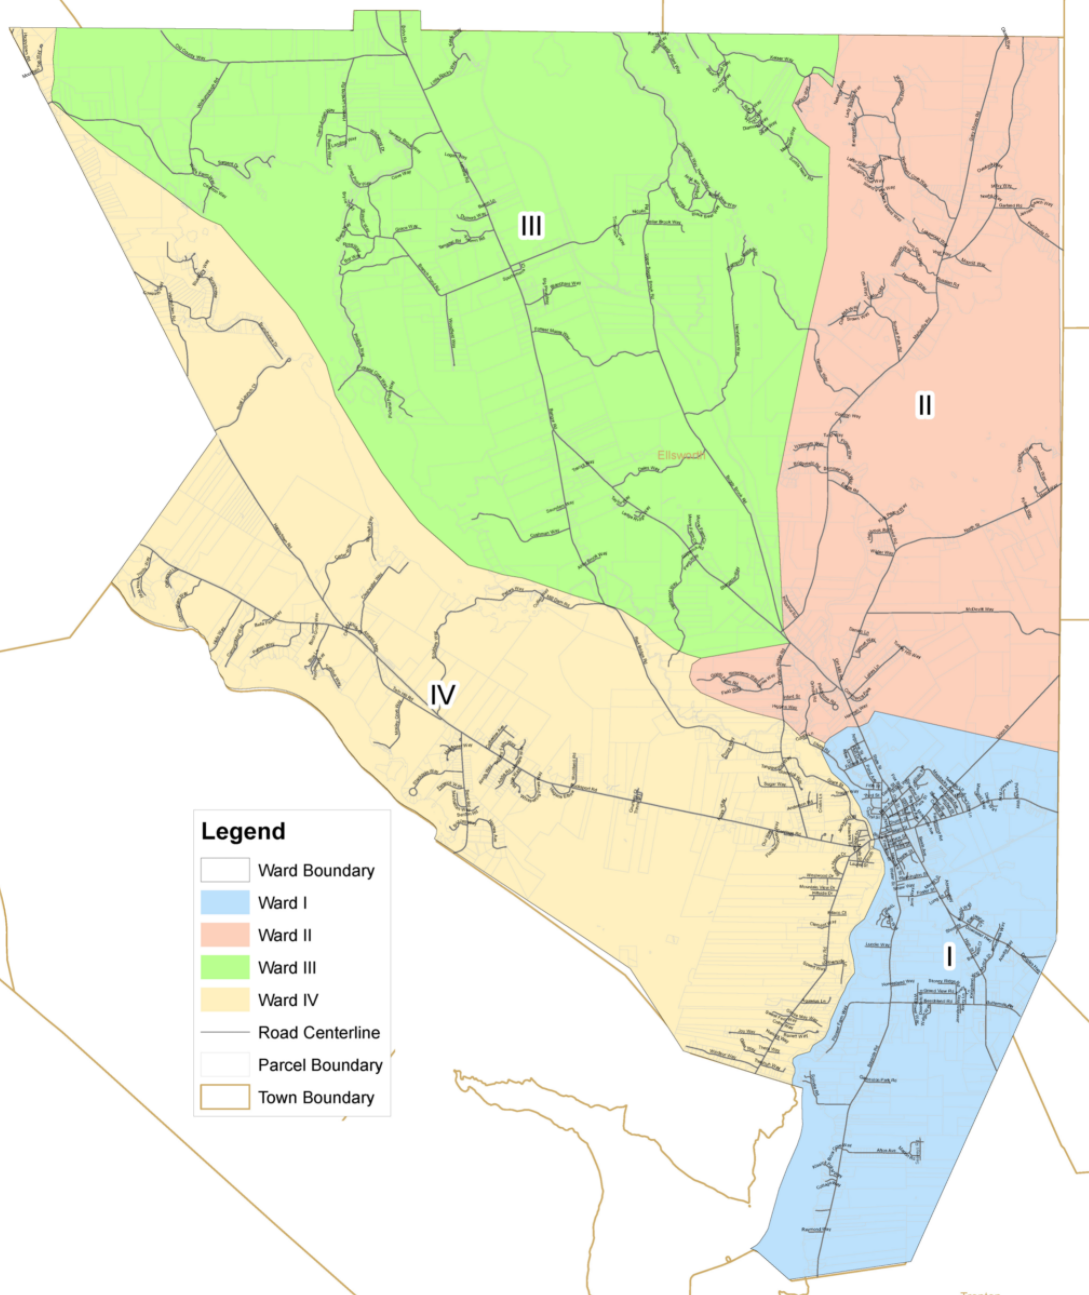

source-https://www.ellsworthmaine.gov/wp-content/uploads/2016/06/Detailed-Ellsworth-Election-Ward-Map-as-of-October-2020.pdf

## Gorham Precincts
VEST-VTDs for Biddeford, Ellsworth, Gorham, Harpswell were sourced from township ward maps.

In [ ]:
ax = vest_me_18[vest_me_18['NAME'].str.contains('Gorham')].boundary.plot(figsize=(20,20),color="red")

### VEST's map appears to match the Gorham precinct map. Precinct Names also appear to match.

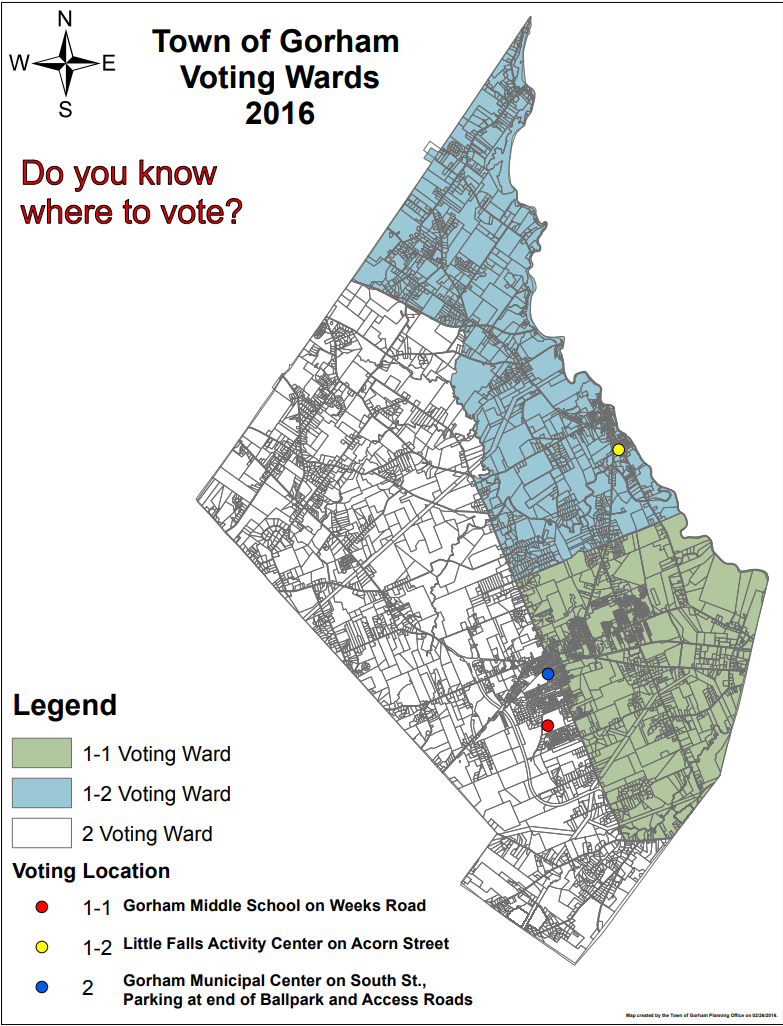

source-https://www.gorham-me.org/sites/g/files/vyhlif4456/f/uploads/voting_ward_map.pdf

## Harpswell Precincts
VEST-VTDs for Biddeford, Ellsworth, Gorham, Harpswell were sourced from township ward maps.

In [ ]:
ax = vest_me_18[vest_me_18['NAME'].str.contains('Harpswell')].boundary.plot(figsize=(20,20),color="red")

### Could not find precinct map for Harpswell